# Intelligent Character Recognition
## 1. Descriere

ICR (Intelligent Character Recognition) presupune un model de recunoaștere și extragere a textului cursiv din poze. Acest model reprezintă o variantă mai sofisticată a OCR (Optical Character Reader) prin faptul că se poate extrage text din orice tip de scris sau font cursiv. În general, pentru implementarea modelului se folosesc rețele neuronale pentru învățarea tipurilor de scris, ce pot avea grade variate de acuratețe.

Pentru setul de date, s-a ales setul Handwriting Recognition (https://www.kaggle.com/datasets/landlord/handwriting-recognition), ce conține 400 de mii de nume scrise de mână, dintre care:
- 206799 prenume
- 207024 nume

Aceste date sunt mai apoi împărțite în:
- set de antrenament (331059 nume)
- set de testare (41382 nume)
- set de validare (41382 nume)

### 1.1 Dependințe

In [25]:
#!pip install opencv-python
!pip install opendatasets

In [26]:
import opendatasets as od
from os.path import isdir
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import LSTM, GRU
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

Running code @ cpu


### 1.2 Încărcarea datelor de antrenament, testare și validare

In [28]:
if not isdir("handwriting-recognition"):
    od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition")

train_data_csv = pd.read_csv("handwriting-recognition/written_name_train_v2.csv")
#train_imgs, train_labels = np.array([np.asarray(Image.open('handwriting-recognition/train_v2/train/'+filename)) for filename in np.array(train_data_csv['FILENAME'])], dtype="object"), np.array(train_data_csv['IDENTITY'])

test_data_csv = pd.read_csv("handwriting-recognition/written_name_test_v2.csv")
#test_imgs, test_labels = np.array([np.asarray(Image.open('handwriting-recognition/test_v2/test/'+filename)) for filename in np.array(test_data_csv['FILENAME'])], dtype="object"), np.array(test_data_csv['IDENTITY'])

validation_data_csv = pd.read_csv("handwriting-recognition/written_name_validation_v2.csv")
#validation_imgs, validation_labels = np.array([np.asarray(Image.open('handwriting-recognition/validation_v2/validation/'+filename)) for filename in np.array(validation_data['FILENAME'])], dtype="object"), np.array(validation_data['IDENTITY'])

### 1.3 Curățarea datelor

Datele de intrare dintr-un set pot să nu fie corect etichetate, etichetele să fie goale sau să fie etichetate cu "UNREADABLE". Dacă eticheta este scrisă cu litere mici, atunci se va schimba în litere mari. Altfel, pentru date corupte sau goale se va aplica ștergerea lor. Datorită tipului de date, nu se va verifica unicitatea.

#### 1.3.1 Date fără etichetă

In [29]:
noEmptyLabels = train_data_csv['IDENTITY'].isnull().sum()
if noEmptyLabels > 0:
    print('Number of NaN label values on train dataset: ', noEmptyLabels)
    train_data_csv.dropna(axis=0, inplace=True)

noEmptyLabels = test_data_csv['IDENTITY'].isnull().sum()
if noEmptyLabels > 0:
    print('Number of NaN label values on test dataset: ', noEmptyLabels)
    test_data_csv.dropna(axis=0, inplace=True)

noEmptyLabels = validation_data_csv['IDENTITY'].isnull().sum()
if noEmptyLabels > 0:
    print('Number of NaN label values on validation dataset: ', noEmptyLabels)
    validation_data_csv.dropna(axis=0, inplace=True)

Number of NaN label values on train dataset:  565
Number of NaN label values on test dataset:  70
Number of NaN label values on validation dataset:  78


TRAIN_00247.jpg
TRAIN_00478.jpg
TRAIN_00951.jpg
TRAIN_01002.jpg
TRAIN_01330.jpg


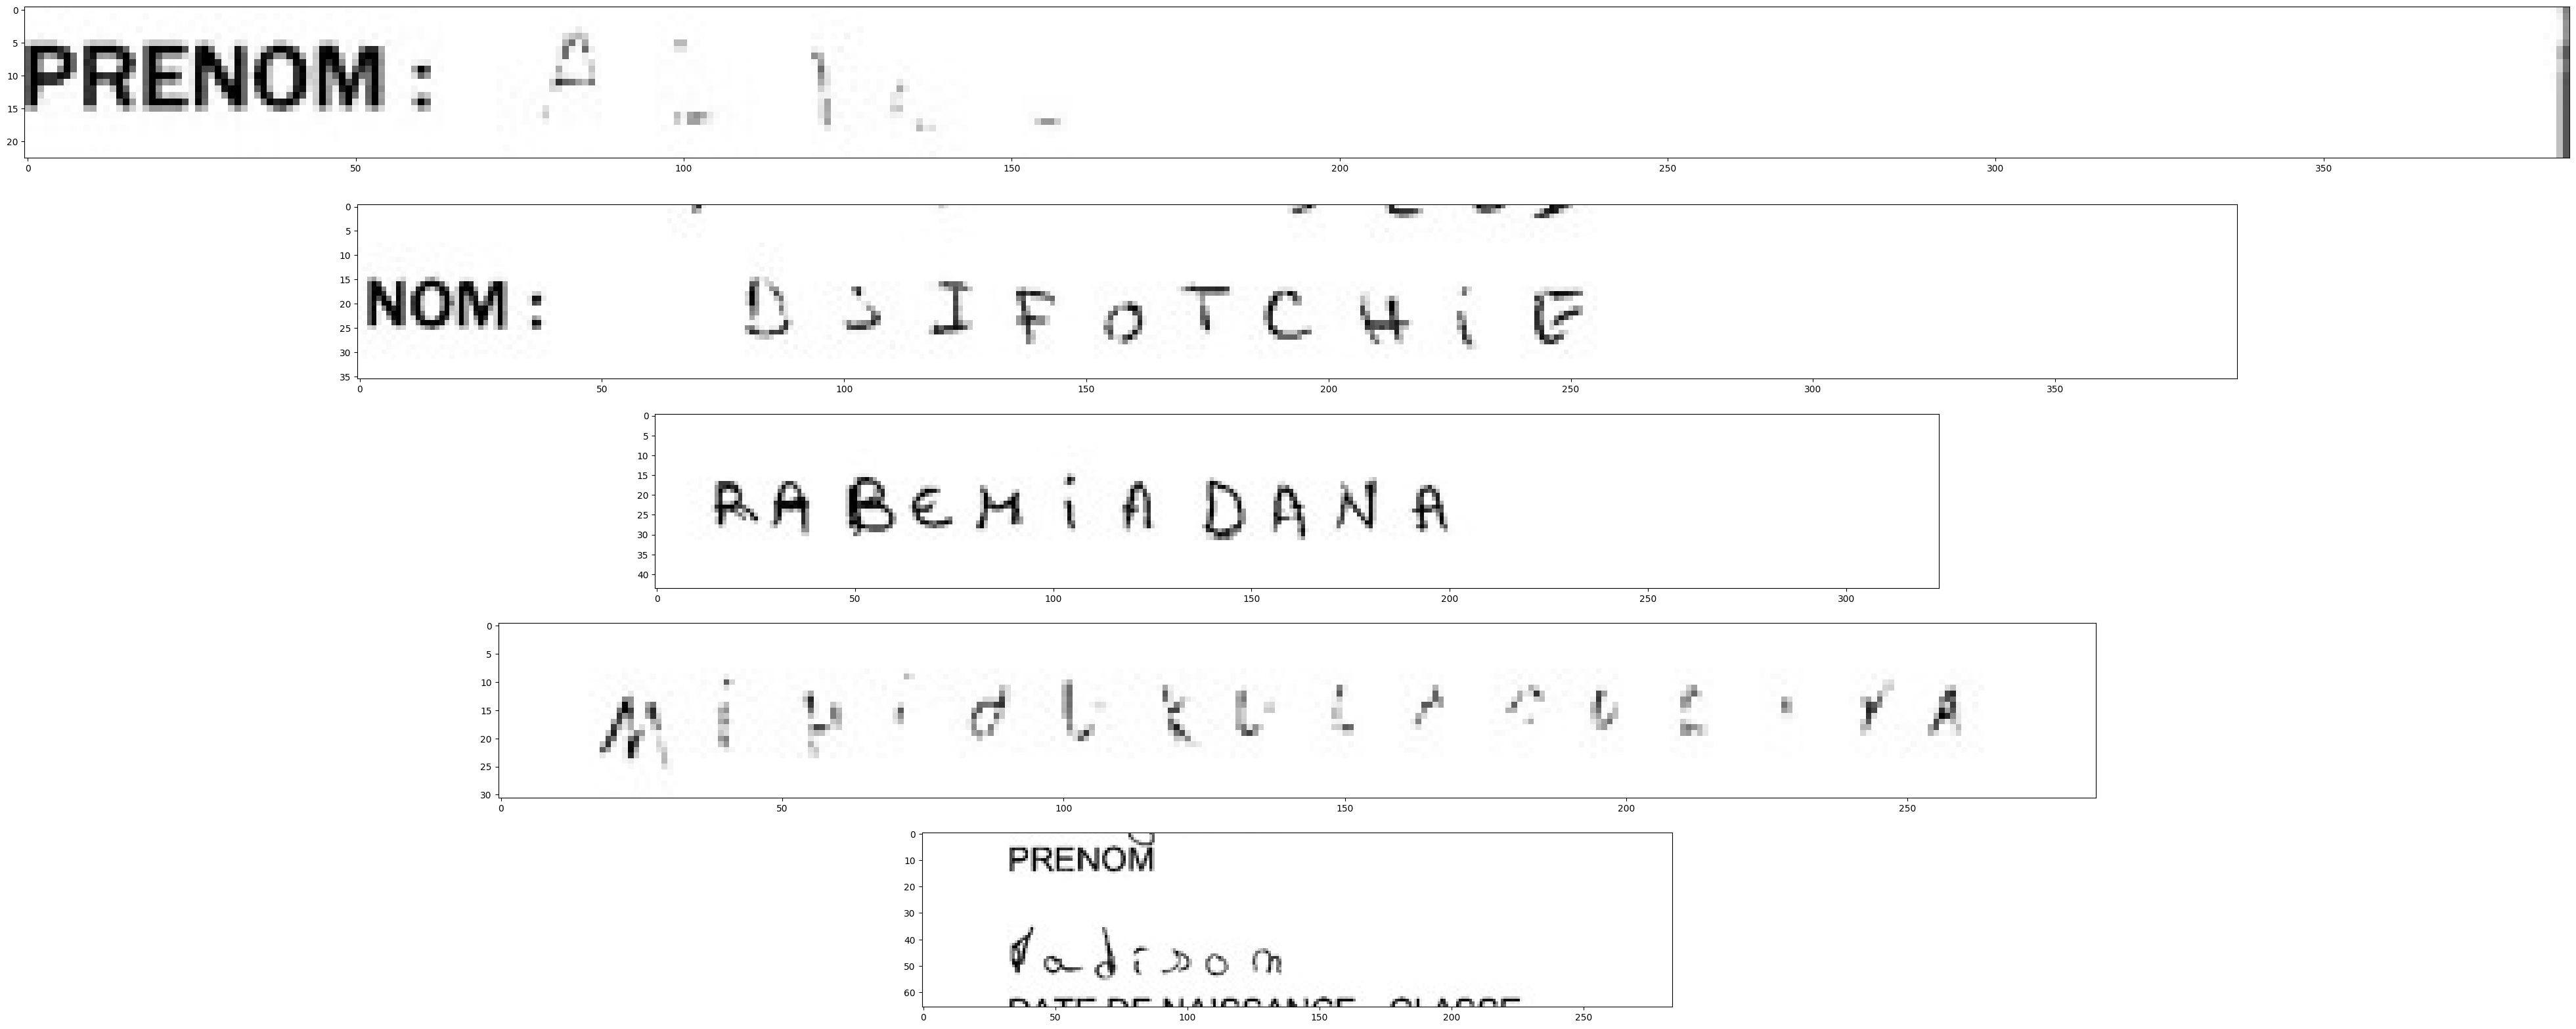

In [30]:
emptyLabels = train_data_csv[train_data_csv['IDENTITY'] == 'EMPTY']
emptyLabels.reset_index(inplace=True, drop=True)

if len(emptyLabels):
    fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(50, 20))
    for i, filename in enumerate(emptyLabels['FILENAME'][:5]):
        print(filename)
        axes[i].imshow(Image.open('handwriting-recognition/train_v2/train/' + filename).convert('LA'))
    plt.show()
    train_data_csv = train_data_csv[train_data_csv['IDENTITY'] != 'EMPTY']

test_data_csv = test_data_csv[test_data_csv['IDENTITY'] != 'EMPTY']
validation_data_csv = validation_data_csv[validation_data_csv['IDENTITY'] != 'EMPTY']

#### 1.3.2 Schimbare în majuscule

In [31]:
train_data_csv['IDENTITY'].str.upper()
test_data_csv['IDENTITY'].str.upper()
validation_data_csv['IDENTITY'].str.upper()

,IDENTITY
0,BILEL
1,LAUMIONIER
2,LEA
3,JEAN-ROCH
4,RUPP
...,...
41365,CHAILLAN
41366,BAROUH
41367,MAXENCE
41368,HAMELIN


#### 1.3.3 Identificarea datelor marcate ca nelizibile

TRAIN_00807.jpg
TRAIN_01220.jpg
TRAIN_02240.jpg
TRAIN_02861.jpg
TRAIN_08931.jpg


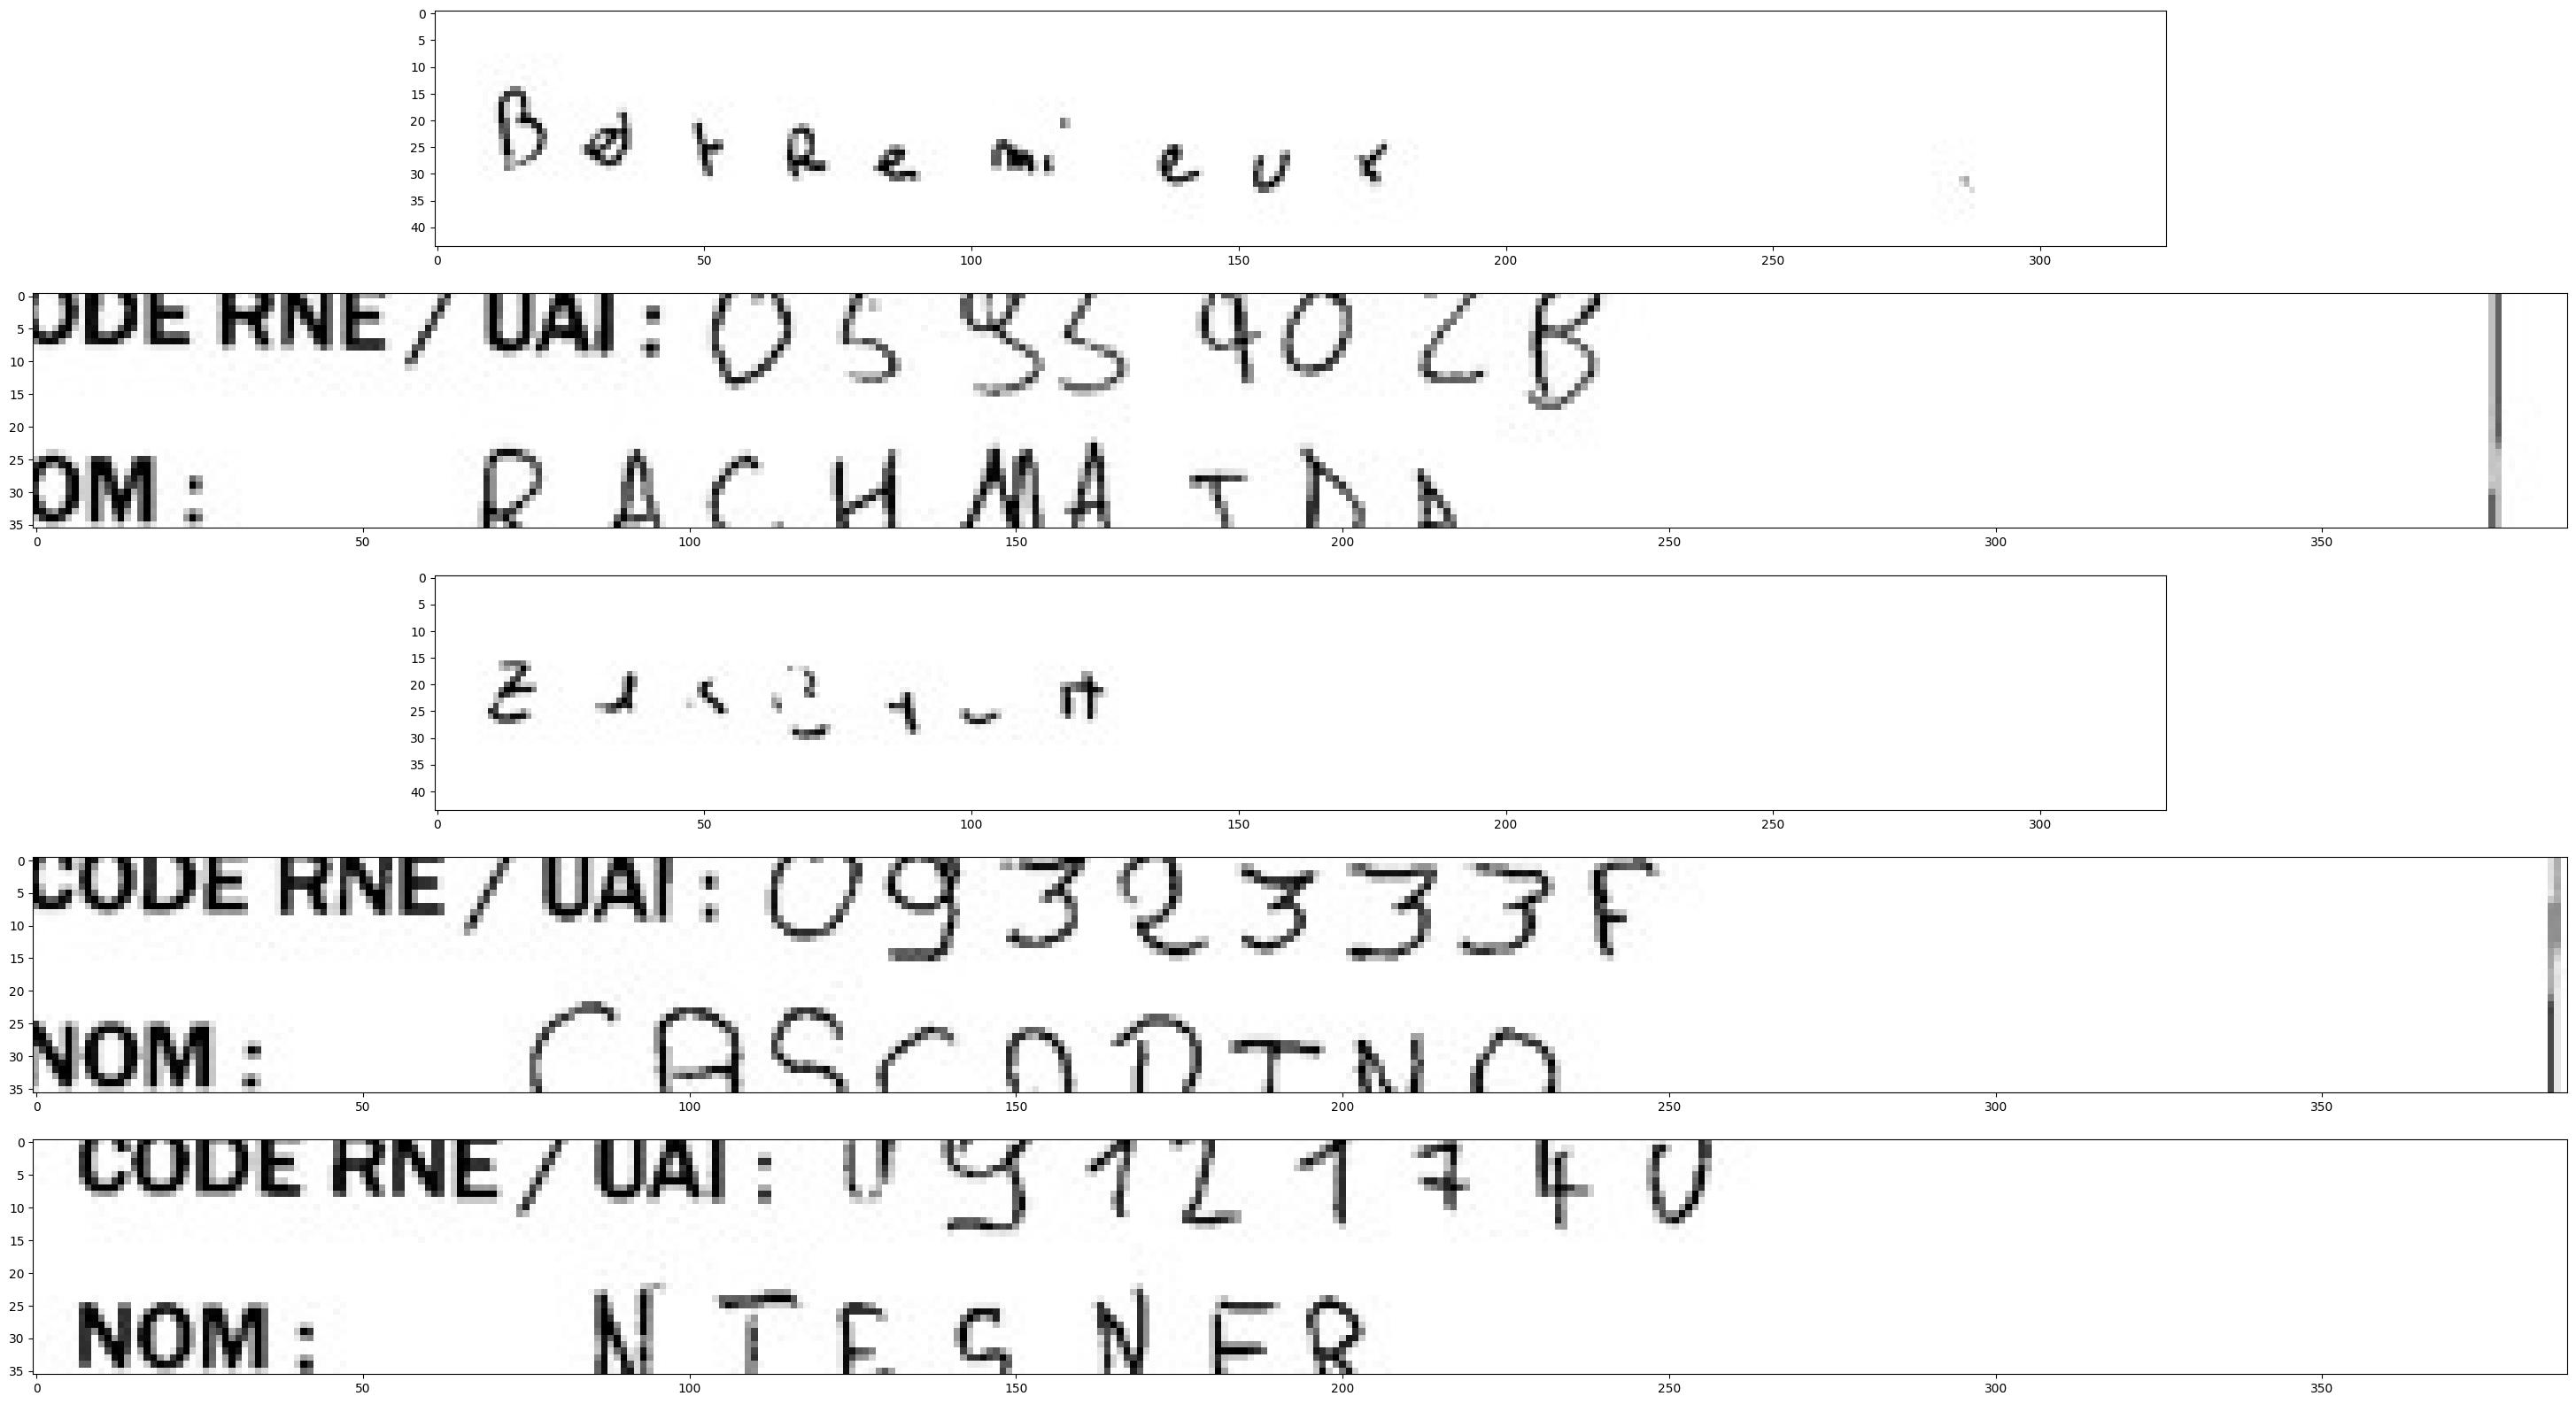

In [32]:
unreadable = train_data_csv[train_data_csv['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

if len(unreadable):
    fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(50, 20))
    for i, filename in enumerate(unreadable['FILENAME'][:5]):
        print(filename)
        axes[i].imshow(Image.open('handwriting-recognition/train_v2/train/' + filename).convert('LA'))
    plt.show()
    train_data_csv = train_data_csv[train_data_csv['IDENTITY'] != 'UNREADABLE']

test_data_csv = test_data_csv[test_data_csv['IDENTITY'] != 'UNREADABLE']
validation_data_csv = validation_data_csv[validation_data_csv['IDENTITY'] != 'UNREADABLE']

### 1.4 Exemple din setul de date

256223    TRAIN_256224.jpg
42970      TRAIN_42971.jpg
85371      TRAIN_85372.jpg
281623    TRAIN_281624.jpg
202730    TRAIN_202731.jpg
Name: FILENAME, dtype: object


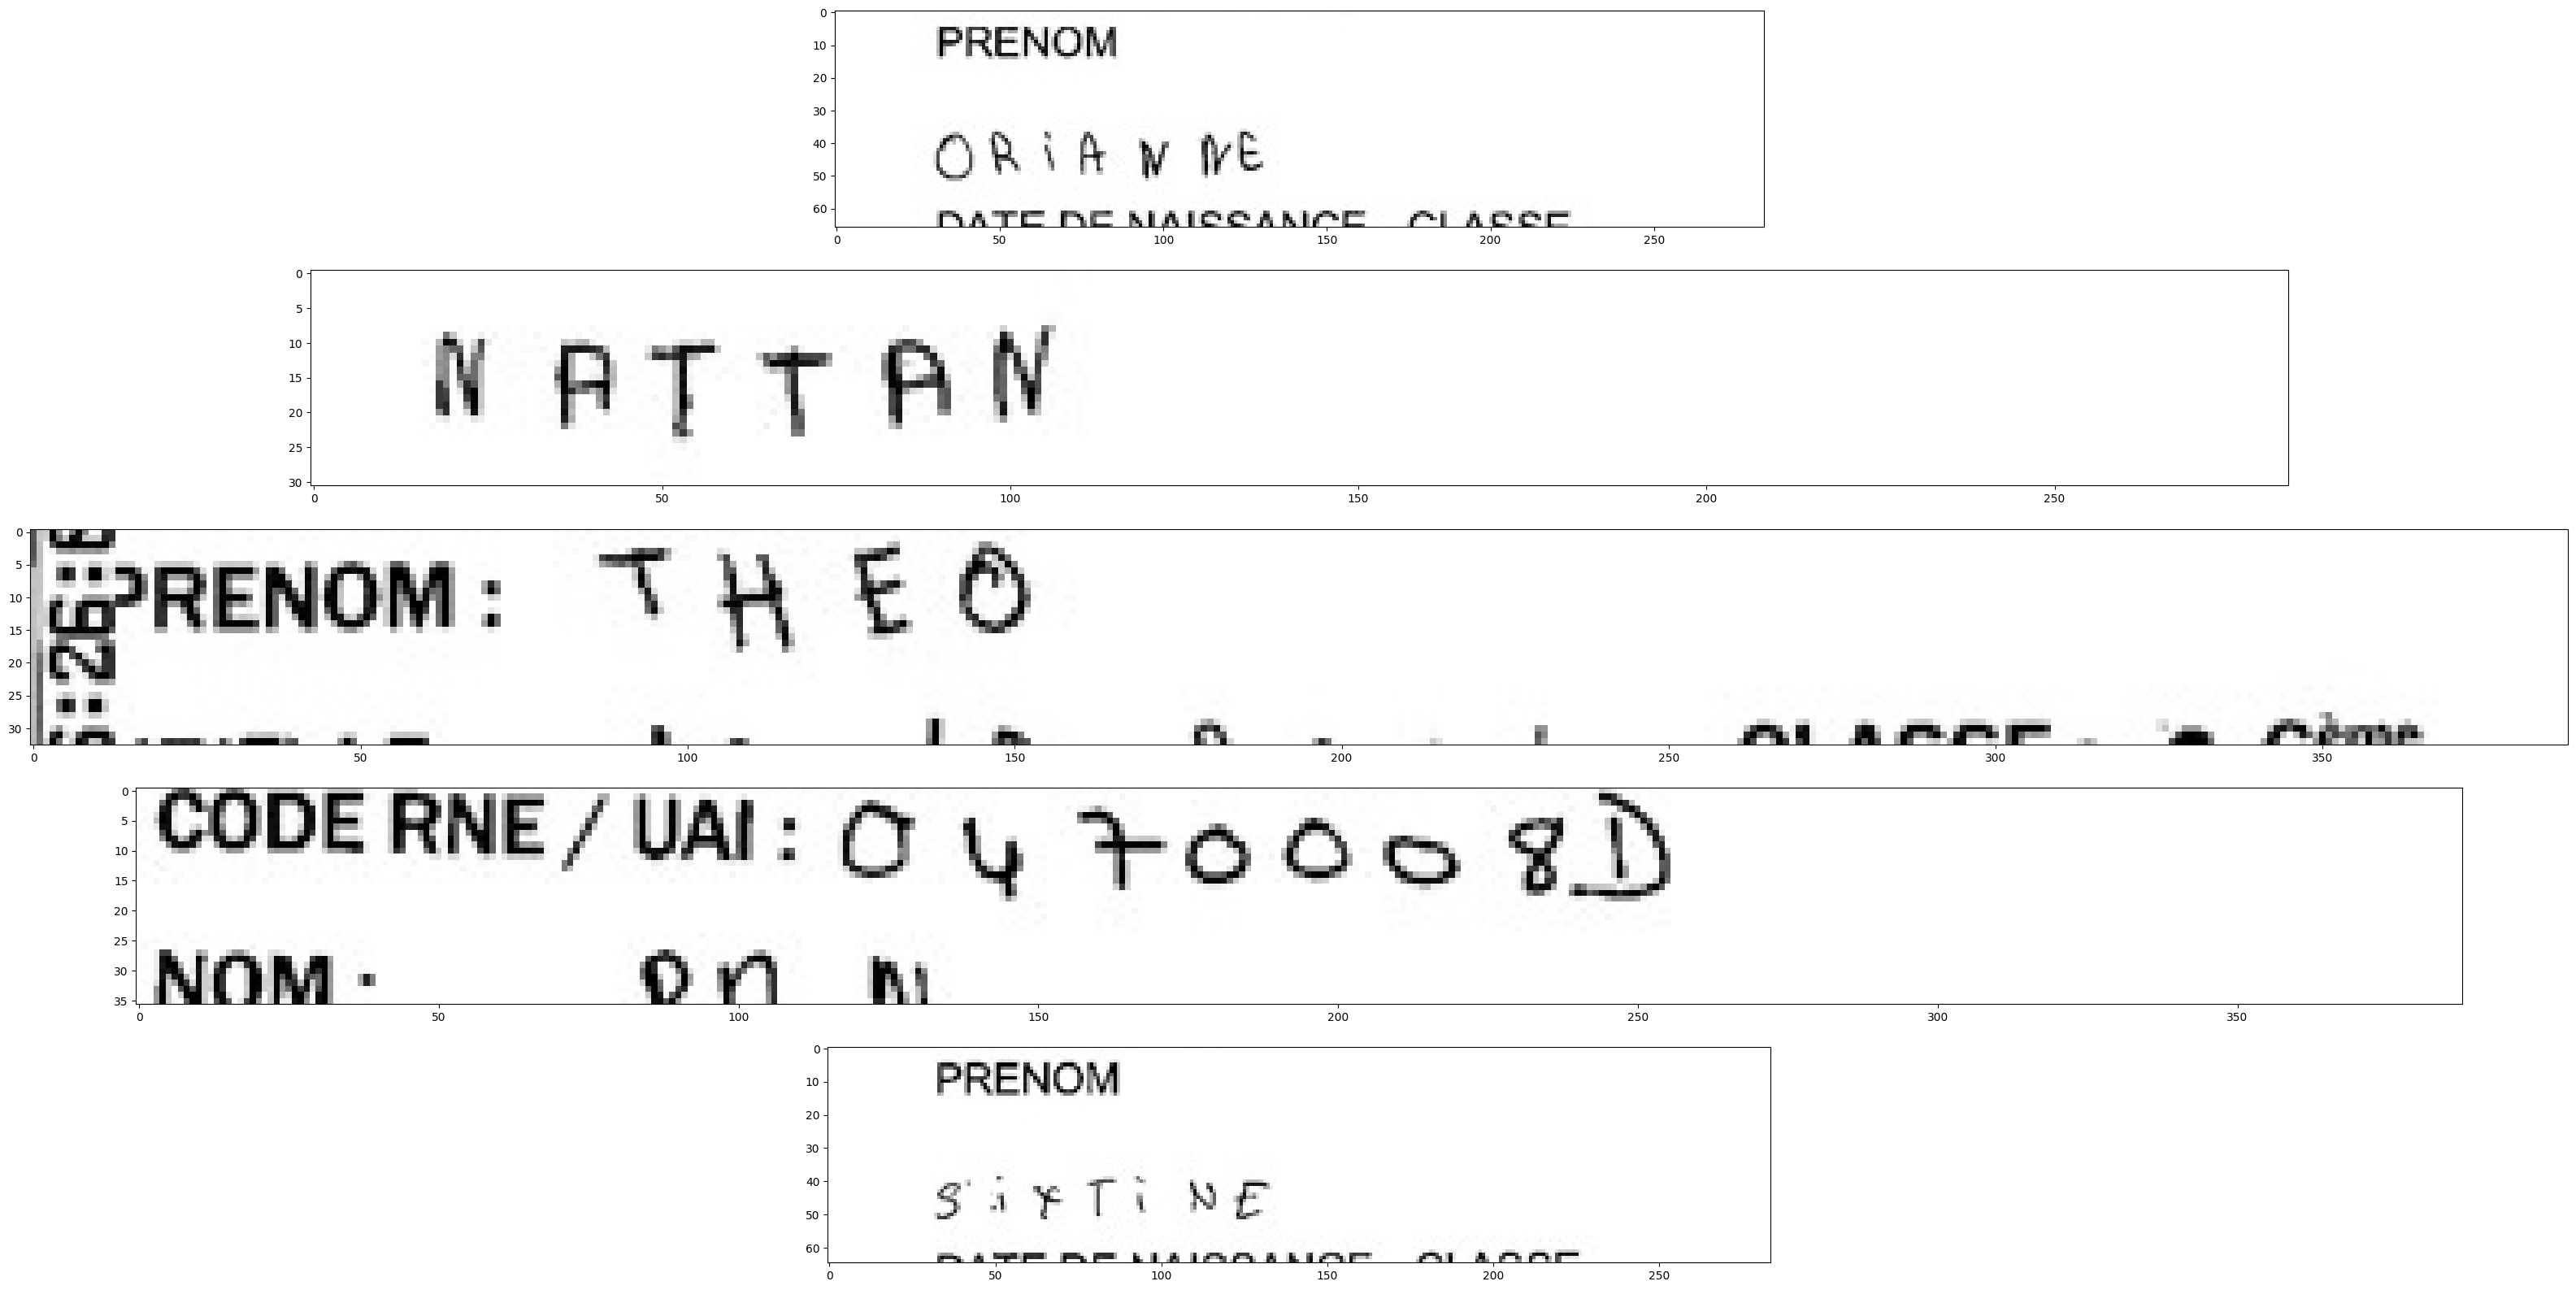

256223    ORIANNE
42970      NATTAN
85371        THEO
281623        ONM
202730    SIYTINE
Name: IDENTITY, dtype: object


In [33]:
idxs = np.random.randint(0, len(train_data_csv), 5)
fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(50, 20))
print(train_data_csv['FILENAME'][idxs])
for i, idx in enumerate(idxs):
    axes[i].imshow(Image.open('handwriting-recognition/train_v2/train/' + train_data_csv['FILENAME'][idx]).convert('LA'))

plt.show()

print(train_data_csv['IDENTITY'][idxs])

### 1.4 Standardizarea datelor

Datele de intrare (imaginile) vor fi rescalate pentru a avea dimensiunile de 255x64

In [34]:
transform = transforms.Compose([
    transforms.Resize((64, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [35]:
def custom_collate_fn(batch):
    images, labels = zip(*batch)  # Separă imagini și etichete
    images = torch.stack(images)  # Stivuiește imaginile (toate au dimensiuni egale)
    labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # Padding pentru etichete
    return images, labels

In [36]:
train_size = 30000
validation_size = 3000
test_size = 3000

In [37]:
train_data = train_data_csv.sample(n=train_size)
validation_data = validation_data_csv.sample(n=validation_size)
test_data = test_data_csv.sample(n=test_size)
train_data.iloc[10]['IDENTITY']

'THOLLET'

In [38]:
class HandwritingDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.df.iloc[idx]['FILENAME'])
        label = self.df.iloc[idx]['IDENTITY']
        chars = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
        image = Image.open(img_path).convert('L')  # Grayscale
        if self.transform:
            image = self.transform(image)

        # Convert label to indices
        label_tensor = torch.tensor([chars.find(c) for c in label])
        return image, label_tensor

In [39]:
train_dataset = HandwritingDataset(train_data, 'handwriting-recognition/train_v2/train/', transform=transform)
validation_dataset = HandwritingDataset(validation_data, 'handwriting-recognition/validation_v2/validation/', transform=transform)
test_dataset = HandwritingDataset(test_data, 'handwriting-recognition/test_v2/test/', transform=transform)

In [40]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, num_workers=2, batch_size=128, collate_fn=custom_collate_fn)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=True, num_workers=2, batch_size=128, collate_fn=custom_collate_fn)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, num_workers=2, batch_size=128, collate_fn=custom_collate_fn)

## 2. Construirea unei rețele de tip convoluționar-recurent

In [41]:
class CRNN(nn.Module):
    def __init__(self, num_classes, img_h, img_w):
        super(CRNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')  # Input channels: 1 (grayscale), Output channels: 32
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,1))
        self.dropout2 = nn.Dropout(0.3)

        # Fully connected layer to connect CNN with RNN
        self.fc1 = nn.Linear(1024, 64)  # 128 * H where H=4 after pooling

        # Recurrent Layers
        self.lstm1 = nn.LSTM(64, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)  # Input: 2*256=512 for bidirectional

        # Output Layer
        self.fc2 = nn.Linear(512, 30)  # 512 comes from bidirectional LSTM output

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)  # Shape: (B, 32, 256, 64)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)  # Shape: (B, 32, 128, 32)

        x = self.conv2(x)  # Shape: (B, 64, 128, 32)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)  # Shape: (B, 64, 64, 16)
        x = self.dropout1(x)

        x = self.conv3(x)  # Shape: (B, 128, 64, 16)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.pool3(x)  # Shape: (B, 128, 64, 8)
        x = self.dropout2(x)

        # Reshape for RNN
        B, C, H, W = x.size()
        x = x.permute(0, 3, 1, 2)  # Shape: (B, W, C, H)
        x = x.reshape(B, W, C * H)  # Shape: (B, H, C*H)

        # Fully connected layer
        x = self.fc1(x)  # Shape: (B, W, 64)
        x = torch.relu(x)

        # Recurrent layers
        x, _ = self.lstm1(x)  # Shape: (B, W, 512)
        x, _ = self.lstm2(x)  # Shape: (B, W, 512)

        # Output layer
        x = self.fc2(x)  # Shape: (B, W, num_of_characters)
        x = self.softmax(x)  # Softmax over the character probabilities
        x = x.reshape(64, B, 30)
        return x

### Antrenare

In [42]:
num_classes = 29  # 'a' to 'z' and special characters (-, ' and whitespace)
model = CRNN(num_classes=num_classes, img_h=64, img_w=256).to(device)

criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
def train_one_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        W, B, H = outputs.size()
        input_lengths = torch.full(size=(B,), fill_value=W, dtype=torch.long)
        target_lengths = torch.tensor([len(label) for label in labels])

        loss = criterion(outputs.log_softmax(2), labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [44]:
def train_model(model_to_train, train_loader, optimizer, criterion, num_epochs=10):
  for epoch in range(num_epochs):
    train_loss = train_one_epoch(model_to_train, train_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

In [ ]:
train_model(model, train_loader, optimizer, criterion)

In [ ]:
def test_model(model_to_test, test_loader, optimizer, criterion):
  pass